# Trabalho Final
### Alunos: Lavínia Louise Rosa Santos e Luís Eduardo Cardoso de Santana




Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import sobel
from skimage.draw import circle_perimeter
from skimage.transform import hough_circle_peaks, hough_circle
from skimage import color
import os

Função para carregar uma imagem do dataset

In [ ]:
def carregar_imagem(pasta, indice):
  #lista todos os arquivos da pasta e ordena
  arquivos = sorted(os.listdir(pasta))

  #verifica se o índice passado existe na lista de arquivos
  if indice >= len(arquivos):
    print("Índice maior que o número de arquivos")
    return

  #monta o caminho do arquivo escolhido
  caminho = os.path.join(pasta, arquivos[indice])

  #lê a imagem em tons de cinza e converte para escala 0 a 255 e tipo uint8
  img = imread(caminho, as_gray=True)
  img = (img * 255).astype(np.uint8)

  return img

Função para extração das bordas (Sobel)

In [ ]:
def aplicar_sobel(img):
  #aplica o operador de Sobel para extrair as bordas da imagem
  bordas = sobel(img)
  bordas = (bordas * 255).astype(np.uint8)
  return bordas

Função para binarização das bordas

In [ ]:
def binarizacao(img):
  #define o limiar como 30% do valor máximo de intensidade das bordas, para preservar apenas os contornos mais fortes
  limiar = 0.3 * img.max()

  #inicializa a imagem binária
  binary = np.zeros_like(img)
  #mantém apenas os pixels de borda de intensidade maior ou igual ao limiar, marcando-os como 1 na imagem binária
  binary[img >= limiar] = 1

  return binary

Função para detectar circunferências usando CHT

In [ ]:
def detectar_circunferencias(img_binaria, raios):
  #gera o acumulador/grade 3D da CHT
  hough_grade = hough_circle(img_binaria, raios)
  #acumulador correspondente ao primeiro raio testado
  grade = hough_grade[0]

  #seleciona os picos do acumulador 3D da CHT que correspondem às circunferências detectadas
  acumuladores, a, b, raio = hough_circle_peaks(
      hough_grade,
      raios,
      total_num_peaks=24 #valor máximo possível para o dataset (correspondente a 4 dados de classe 6)
  )

  #retorna acumulador 3D, acumulador do primeiro raio e parâmetros das circunferências
  return hough_grade, grade, a, b, raio

Função para fazer a limiarização do acumulador

In [ ]:
def limiarizacao_acumulador(acumulador):
  #obtém, para cada posição, o maior número de votos no acumulador 3D considerando todos os raios
  acumulador_max = acumulador.max(axis=0)
  #define o limiar como 61% do maior valor de votos do acumulador
  limiar = 0.61 * acumulador_max.max()

  #cria a imagem binária que irá armazenar apenas os picos do acumulador
  acumulador_bin = np.zeros_like(acumulador_max, dtype=np.uint8)
  #mantém (marca com 1) apenas as posições cujo número de votos é maior ou igual ao limiar, que correspondem aos melhores candidatos a centros
  acumulador_bin[acumulador_max >= limiar] = 1

  return acumulador_bin

Função para filtrar os centros por distância

In [ ]:
def filtrar_centros_distancia(centros, distancia_min):
  #lista para armazenar apenas os centros aceitos
  centros_aceitos = []

  #percorre todos os centros candidatos
  for c in centros:
    c = np.array(c)
    outro = True

    #compara o centro atual com os já aceitos
    for ca in centros_aceitos:
      #calcula a distância entre os dois centros
      if np.linalg.norm(c - ca) < distancia_min:
        #se estiver a uma distância menor que a mínima definida, é considerado redundante e não é aceito
        outro = False
        break

    if outro:
      #se não for redundante adiciona à lista dos aceitos
      centros_aceitos.append(c)

  #retorna a lista dos centros aceitos
  return np.array(centros_aceitos)

Função para desenhar as circunferências encontradas na imagem

In [ ]:
def desenhar_circunferencias(img, centros_aceitos, raios):
  dados_color = color.gray2rgb(img)

  #define o raio desenhado como a média dos raios encontrados
  raio_desenho = int(np.mean(raios))

  #desenha os centros encontrados na imagem
  for (a, b) in centros_aceitos:
    dados_color[a-4:a+5, b-4:b+5] = [255, 0, 0]

  espessura=2

  #desenha cada circunferência encontrada
  for (y, x) in centros_aceitos:
    #usa vários raios próximos para aumentar a espessura da borda e melhorar a visualização
    for r in range(raio_desenho - espessura, raio_desenho + espessura + 1):
      circ_y, circ_x = circle_perimeter(
          y, x, r,
          shape=img.shape
      )

      #desenha a circunferência em azul
      dados_color[circ_y, circ_x] = (0, 0, 220)

  return dados_color

Função para identificar e classificar cada dado

In [ ]:
def identificar_dados(centros):
  #caso não receba nenhum centro, retorna lista vazia
  if len(centros) == 0:
    return []

  #converte para array numpy para cálculos
  centros = np.array(centros, dtype=float)
  #quantidade de centros
  N = len(centros)

  #lista booleana para controlar quais centros já foram agrupados
  visitado = np.zeros(N, dtype=bool)
  #lista para armazenar os grupos formados/dados detectados
  grupos = []

  #distancia máxima entre os centros para serem considerados do mesmo grupo/dado
  distancia = 150

  #para cada centro
  for i in range(N):
    #pula se já está em algum grupo/dado
    if visitado[i]:
      continue

    #incia um novo grupo a partir do centro analisado, marcando-o como já visitado, ou seja, agrupado
    fila = [i]
    visitado[i] = True
    grupo = [i]

    #loop para inserir no grupo criado todos os centros próximos a ele
    #enquanto houver centros na fila
    while fila:
      #pega o próximo centro do grupo atual para verificar quem está perto dele
      u = fila.pop(0)

      #calcula a distância do centro 'u' para todos os outros
      dist = np.linalg.norm(centros - centros[u], axis=1)

      #encontra centros dentro da distância definida e ainda não visitados
      vizinhos = np.where((dist <= distancia) & (~visitado))[0]

      #inclui esses vizinhos no mesmo grupo, marcando-os como visitados
      for v in vizinhos:
        visitado[v] = True
        fila.append(v)
        grupo.append(v)

    #salva o grupo formado o qual corresponde a um dado detectado
    grupos.append(grupo)

  return grupos

Função para exibir dados detectados e classificados

In [ ]:
def classifica_dados(img, grupos, centros_aceitos):
  dados_color = color.gray2rgb(img)

  #para cada grupo/dado encontrado
  for grupo in grupos:
    #obtém as coordenadas de todos os centros do grupo
    pontos = np.array([centros_aceitos[i] for i in grupo])
    ys = pontos[:,0]
    xs = pontos[:,1]

    #encontra o menor e maior x e y dos centros para definir a região do grupo
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    #classe do dado = quantidade de circunferências no grupo
    classe_dado = len(grupo)

    #escreve o rótulo da classe acima do dado
    plt.text(
        x_min - 50,
        y_min - 90,
        f"classe_{classe_dado}",
        color='yellow',
        fontsize=12,
        weight='bold',
        bbox=dict(facecolor='black', alpha=0.6, pad=2)
    )

    #aumenta região do grupo para definir um retângulo que englobe melhor cada dado
    y_min -= 80
    y_max += 80
    x_min -= 80
    x_max += 80

    #garante que o retângulo não ultrapasse os limites da imagem
    y_min = max(0, y_min)
    x_min = max(0, x_min)
    y_max = min(img.shape[0]-1, y_max)
    x_max = min(img.shape[1]-1, x_max)

    #define a cor da borda como vermelha
    cor = (0, 0, 255)

    #desenha o retângulo com uma espessura maior
    for k in range(6):
      dados_color[y_min:y_max, x_min+k] = cor
      dados_color[y_min:y_max, x_max-k] = cor
      dados_color[y_min+k, x_min:x_max] = cor
      dados_color[y_max-k, x_min:x_max] = cor

  return dados_color

Preparação da Imagem e Detecção das Circunferências

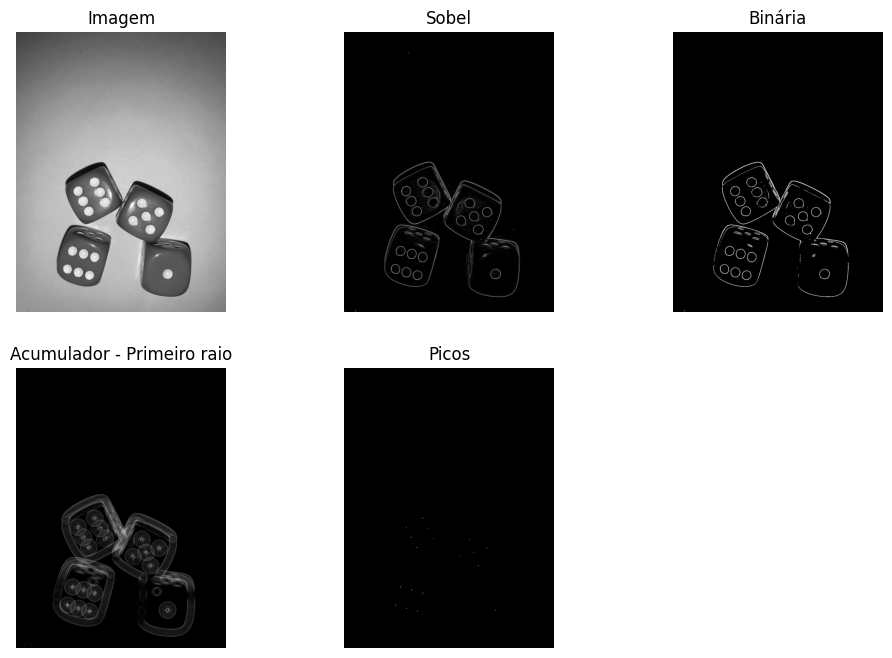

In [ ]:
#carregando a imagem
#crie uma pasta chamada dataset nos arquivos e coloque as imagens dentro dela
img = carregar_imagem('dataset', 1) #troque o indice para testar com imagens diferentes (0 a 14)
#exibe imagem carregada
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title("Imagem")
plt.axis('off')

#aplicando sobel para extrair as bordas
bordas = aplicar_sobel(img)
#exibe imagem das bordas
plt.subplot(2,3,2)
plt.imshow(bordas, cmap='gray')
plt.title("Sobel")
plt.axis('off')

#extraindo a imagem binária das boras
binary = binarizacao(bordas)
#exibe imagem binária das bordas
plt.subplot(2,3,3)
plt.imshow(binary, cmap='gray')
plt.title("Binária")
plt.axis('off')

#definindo o conjunto de raios de teste
raios = np.arange(20, 30, 1)

#aplicando CHT para detectar as circunferências
hough_grade, grade, a, b, raio = detectar_circunferencias(binary, raios)

#exibindo acumulador do primeiro raio
plt.subplot(2,3,4)
plt.imshow(grade, cmap='gray')
plt.title("Acumulador - Primeiro raio")
plt.axis('off')

#fazendo a limiarização do acumulador
acumulador_bin = limiarizacao_acumulador(hough_grade)
#exibindo imagem binária do acumulador
plt.subplot(2,3,5)
plt.imshow(acumulador_bin, cmap='gray')
plt.title("Picos")
plt.axis('off')

#obtém as coordenadas dos picos do acumulador
centros_candidatos = np.argwhere(acumulador_bin == 1)

#remove os centros muito próximos entre si
centros_aceitos = filtrar_centros_distancia(centros_candidatos, 11)

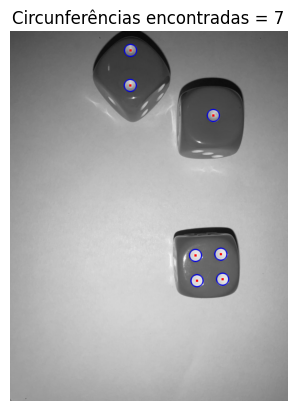

In [ ]:
#exibindo circunferências encontradas
dados_color = desenhar_circunferencias(img, centros_aceitos, raios)
plt.imshow(dados_color)
plt.title(f"Circunferências encontradas = {len(centros_aceitos)}")
plt.axis('off')
plt.show()

Classificando os dados

Quantidade de dados: 3
Classes achadas: [2, 1, 4]


(np.float64(-0.5), np.float64(1107.5), np.float64(1477.5), np.float64(-0.5))

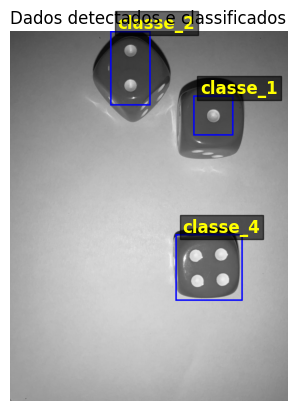

In [ ]:
#identificando cada dado e sua classe
dados_qtd = identificar_dados(centros_aceitos)
print("Quantidade de dados:", len(dados_qtd))
print("Classes achadas:", [len(dado) for dado in dados_qtd])

#exibindo dados classificados
img_final = classifica_dados(img, dados_qtd, centros_aceitos)
plt.imshow(img_final)
plt.title("Dados detectados e classificados")
plt.axis('off')